In [207]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.compose import ColumnTransformer
import numpy as np
from catboost import CatBoostClassifier, Pool
import ast

In [293]:
#загружаем трэйн
df_orders_flat = pd.read_parquet(r'C:\Users\Alex\Desktop\data_science\мфти\хакатон\flockery\df_orders_flat_out.parquet')

In [282]:

#дропаем лишние столбцы (если они есть)
#columns_to_drop = ['median_length',  'average_common_categories', 'average_categories']
#df_orders_flat = df_orders_flat.drop(columns=columns_to_drop)

In [294]:
#загружаем валидацию
val = pd.read_parquet(r'C:\Users\Alex\Desktop\data_science\мфти\хакатон\flockery\vers2\val_test.parquet')

In [297]:

def preprocess_dataframe(df):
    # Удаление выбранных столбцов
    #columns_to_drop = ['num_categories',	'num_common_categories',  'male_cat',	'female_cat']
    #df = df.drop(columns=columns_to_drop)

    # Сбрасываем индексы, чтобы избежать дубликатов после explode
    df = df.reset_index(drop=True)
    #делаем explode для general-category-path   
    df = df.explode('general-category-path')
    
    
    df['id'] = df['id'].str.replace('item_', '')
    # Замена NaN на 0
    df = df.fillna(0)

    # Преобразование столбцов в int16
    int16_columns = ['site-id', 'count']
    df[int16_columns] = df[int16_columns].astype('int16')

    # Удаление слова 'user' в каждой строке столбца 'user_id'
    df['user_id'] = df['user_id'].str.replace('user_', '')

    # Преобразование столбца 'user_id' в int32
    df['user_id'] = df['user_id'].astype('int32')
    df['general-category-path'] = df['general-category-path'].astype('int32')
    
    df['brand-id'] = df['brand-id'].astype('int32')

       # Обработка столбца 'id'
    df['id'] = df['id'].astype('int32')
    

    # Преобразование 'target' в числовое представление
    df['target'] = df['target'].map({'male': 0, 'female': 1})

    return df




In [298]:

df_orders_flat = preprocess_dataframe(df_orders_flat)

In [ ]:
val = preprocess_dataframe(val)

In [265]:

df_orders_flat

,user_id,target,length,site-id,created-at,id,count,general-category-path,brand-id
0,1,1,3,1,1.634292e+09,0,0,0,0
1,1,1,3,2,1.639827e+09,0,0,0,0
2,1,1,3,2,1.639828e+09,0,0,0,0
3,2,1,11,0,0.000000e+00,0,0,0,0
4,5,1,35,39,1.644809e+09,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2122026,127751,0,11,16,1.649580e+09,56817,1,10604398,3503
2122026,127751,0,11,16,1.649580e+09,56817,1,91009,3503
2122027,127752,0,13,147,1.612968e+09,0,0,0,0
2122028,127752,0,13,147,1.612969e+09,0,0,0,0


In [266]:
val

,user_id,target,length,site-id,created-at,id,count,general-category-path,brand-id
0,127756,1,8,407,1.697126e+09,676374,0,0,0
1,127757,0,16,16,1.636574e+09,3780263,2,90578,1237
1,127757,0,16,16,1.636574e+09,3780263,2,90574,1237
1,127757,0,16,16,1.636574e+09,3780263,2,198118,1237
2,127757,0,16,16,1.637513e+09,5403882,2,90578,1237
...,...,...,...,...,...,...,...,...,...
815457,155202,1,45,300,1.688068e+09,650362,1,818863,915491
815457,155202,1,45,300,1.688068e+09,650362,1,15068776,915491
815457,155202,1,45,300,1.688068e+09,650362,1,7811881,915491
815457,155202,1,45,300,1.688068e+09,650362,1,7877999,915491


In [152]:
df_orders_flat

,user_id,target,site-id,created-at,count,brand-id
0,1,1,1,1.634292e+09,0,0.0
1,1,1,2,1.639827e+09,0,0.0
2,1,1,2,1.639828e+09,0,0.0
3,2,1,0,0.000000e+00,0,0.0
4,5,1,39,1.644809e+09,0,0.0
...,...,...,...,...,...,...
2122025,127751,0,16,1.648560e+09,1,1446.0
2122026,127751,0,16,1.649580e+09,1,3503.0
2122027,127752,0,147,1.612968e+09,0,0.0
2122028,127752,0,147,1.612969e+09,0,0.0


In [288]:
# Разделение данных на train и test
X_train = df_orders_flat.drop(columns=['target'])
y_train = df_orders_flat['target']
X_test = val.drop(columns=['target'])
y_test = val['target']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [289]:
X_test

,user_id,length,site-id,created-at,id,count,general-category-path,brand-id,num_categories,num_common_categories,male_cat,female_cat
0,127756,8,407,1.697126e+09,676374,0,0,0,0,0,0,0
1,127757,16,16,1.636574e+09,3780263,2,90578,1237,3,3,0,0
1,127757,16,16,1.636574e+09,3780263,2,90574,1237,3,3,0,0
1,127757,16,16,1.636574e+09,3780263,2,198118,1237,3,3,0,0
2,127757,16,16,1.637513e+09,5403882,2,90578,1237,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
815457,155202,45,300,1.688068e+09,650362,1,818863,915491,4,4,0,0
815457,155202,45,300,1.688068e+09,650362,1,15068776,915491,4,4,0,0
815457,155202,45,300,1.688068e+09,650362,1,7811881,915491,4,4,0,0
815457,155202,45,300,1.688068e+09,650362,1,7877999,915491,4,4,0,0


In [290]:

# Создание DMatrix для XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Определение параметров
param = {
    'max_depth': 3,  # глубина деревьев
    'eta': 0.3,  # шаг обучения
    'objective': 'binary:logistic',  # тип задачи
    'eval_metric': 'error'  # метрика оценки
}


# Обучение модели
num_round = 80 #эпохи
evals = [(dtest, 'test'), (dtrain, 'train')]
evals_result = {}
bst = xgb.train(param, dtrain, num_round, evals, early_stopping_rounds=10, evals_result=evals_result)

# Предсказание на тестовом наборе данных
preds = bst.predict(dtest)
predictions = [round(value) for value in preds]

# Вычисление точности
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

plt.figure(figsize=(10,5))
plt.plot(evals_result['train']['error'], label='Train')
plt.plot(evals_result['test']['error'], label='Test')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('XGBoost Training Process')
plt.legend()
plt.grid(True)
plt.show()

KeyboardInterrupt: 

In [71]:
X_test

,user_id,length,site-id,created-at,count,brand-id,num_categories,num_common_categories,male_cat,female_cat
280352,24420,55,11,1.535017e+09,2,0.0,0,0,0,0
1964400,96454,11,41,1.679192e+09,1,0.0,0,0,0,0
558471,48895,58,58,1.679130e+09,1,4793.0,3,3,0,0
568412,49746,79,245,1.656618e+09,0,0.0,0,0,0,0
2025682,109411,26,2,1.549586e+09,1,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1098994,93754,41,341,1.531248e+09,1,0.0,0,0,0,0
1137886,97403,74,97,1.635397e+09,4,25694.0,3,3,0,0
1683889,40307,12,62,1.575693e+09,1,0.0,3,3,0,0
1298537,111265,41,173,1.689244e+09,1,0.0,4,4,0,0


In [291]:



# Создание пула данных для CatBoost
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

# Определение параметров
params = {
    'iterations': 190,
    'depth': 3,
    'learning_rate':0.3,
    'l2_leaf_reg': 5,
    'loss_function': 'Logloss',
    'eval_metric': 'Accuracy',
    'verbose': 10
}

# Создание и обучение модели
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=test_pool, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7414040	test: 0.7079729	best: 0.7079729 (0)	total: 619ms	remaining: 1m 57s
10:	learn: 0.7494667	test: 0.7134881	best: 0.7134881 (10)	total: 6.09s	remaining: 1m 39s
20:	learn: 0.7609359	test: 0.7197603	best: 0.7201413 (19)	total: 11.5s	remaining: 1m 32s
30:	learn: 0.7661917	test: 0.7234553	best: 0.7234553 (30)	total: 16.8s	remaining: 1m 26s
40:	learn: 0.7693110	test: 0.7250436	best: 0.7250436 (40)	total: 22.1s	remaining: 1m 20s
50:	learn: 0.7719837	test: 0.7256270	best: 0.7259720 (47)	total: 27.1s	remaining: 1m 13s
60:	learn: 0.7740328	test: 0.7266788	best: 0.7266788 (60)	total: 32s	remaining: 1m 7s
70:	learn: 0.7755385	test: 0.7275957	best: 0.7275973 (69)	total: 37s	remaining: 1m 2s
80:	learn: 0.7774971	test: 0.7283336	best: 0.7283674 (79)	total: 42.1s	remaining: 56.6s
90:	learn: 0.7789888	test: 0.7288772	best: 0.7288772 (90)	total: 47.1s	remaining: 51.2s
100:	learn: 0.7797374	test: 0.7290950	best: 0.7290950 (100)	total: 51.9s	remaining: 45.8s
110:	learn: 0.7806215	test: 0.

c:\Users\Alex\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	test-error:0.00000	train-error:0.00000
[1]	test-error:0.00000	train-error:0.00000
[2]	test-error:0.00000	train-error:0.00000
[3]	test-error:0.00000	train-error:0.00000
[4]	test-error:0.00000	train-error:0.00000
[5]	test-error:0.00000	train-error:0.00000
[6]	test-error:0.00000	train-error:0.00000
[7]	test-error:0.00000	train-error:0.00000
[8]	test-error:0.00000	train-error:0.00000
[9]	test-error:0.00000	train-error:0.00000
[10]	test-error:0.00000	train-error:0.00000


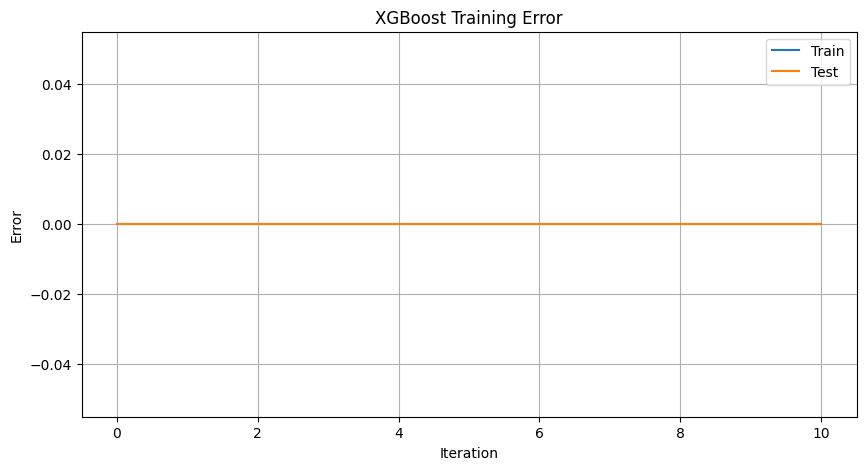

In [68]:


# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование данных в DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Определение параметров
param = {
    'max_depth': 3,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'error'
}

# Обучение модели
num_round = 20

# Обучение модели
evals_result = {}
bst = xgb.train(param, dtrain, num_round, evals, early_stopping_rounds=10, evals_result=evals_result)

# Визуализация процесса обучения
plt.figure(figsize=(10,5))
plt.plot(evals_result['train']['error'], label='Train')
plt.plot(evals_result['test']['error'], label='Test')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('XGBoost Training Error')
plt.legend()
plt.grid(True)
plt.show()
